# Assembly kmer estimates

We wish to the following properties of a genome based on the kmer histogram. Formally, we have as our input:

- $K_i$, where $i = 1..100001$, as the number of kmers at coverage $i$

We want to infer:

- $G_i$, where $i = 1..100$, as the number of kmers with copy number of $i$ in the genome sequence

This $G_i$ spectrum is interesting since it allows us to estimate

- Genome size $g = \sum_{i=1}^{100}{i * G_i}$

- Ploidy $p$ where $\sum_{i=1}^{p}{G_i} > 0.95 * \sum_{i=1}^{100}{G_i}$, i.e. with this ploidy you can explain most of the unique kmers in the genome

- Repeat contents $R = \sum_{i=p}^{100}{i * G_i} / \sum_{i=1}^{100}{i * G_i}$, ratio of all high copy kmers (larger than ploidy $p$) over all genome kmers

- Heterozygosity. Formula TBD.

$G_i$ can generate the expected $K_i$ which we can use to match to the observed $K_i$. The objective function can be minimize the K-L divergence.

- $D_{KL}(P | Q)$, where $P$ is the observed $K_i$ and $Q$ is the expected $K_i$, which is the amount of information lost when $Q$ is used to approximate $P$.

In [35]:
%matplotlib inline
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

11:35:26 [pyplot] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Sampling

In [94]:
from scipy.stats import nbinom
import numpy as np

In [143]:
def nbinom_pmf(x, lambda_, rho):
    sigma = rho * lambda_
    n = lambda_ ** 2 / (sigma - lambda_)
    p = lambda_ / sigma
    return nbinom.pmf(x, n, p)

def plot_negative_binomial(x, lambda_, rho=1.2, color='b'):
    y = nbinom.pmf(x, lambda_, rho)
    plt.plot(x, y, '-', color=color)
    return y

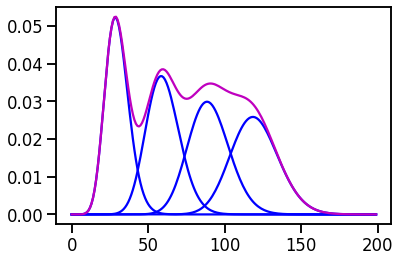

In [117]:
# Start multiple series at 30, 60, 90, 120
x = np.arange(200)
stacked_y = np.zeros(len(x))
for lambda_ in (30, 60, 90, 120):
    stacked_y += plot_negative_binomial(x, lambda_, rho=2, color='b')
plt.plot(x, stacked_y, "-", color='m')

In [132]:
# Read in real data
def parse_hist(filename="reads.histo"):
    hist = [0] * 10002
    with open(filename) as fp:
        for row in fp:
            cov, count = row.split()
            cov, count = int(cov), int(count)
            hist[cov] = count
    return np.array(hist)

hist = parse_hist()

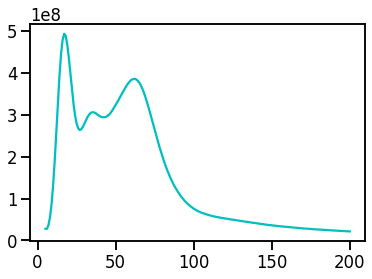

In [140]:
x = np.arange(5, 201, dtype=np.int)
y = hist[x] * x
plt.plot(x, y, "c-")

In [142]:
# Decompose the truncated histogram
X = np.arange(1, len(hist), dtype=np.int)
Y = hist[X] * X
total = Y.sum()
print(total)
print(y.sum())

46605857762
29574390523


In [244]:
from scipy.stats import entropy

coverage_range = np.arange(5, 201, dtype=np.int)
P = Y[coverage_range]

def generative_model(G, lambda_, rho):
    stacked = np.ones(len(coverage_range), dtype=np.float64)
    for i, g in enumerate(G):
        stacked += g * nbinom_pmf(coverage_range, lambda_ * (i + 1), rho) * coverage_range
    return stacked

def funcKL(lambda_, rho, G):
    stacked = generative_model(G, lambda_, rho)
    return entropy(P, stacked)

def func(lambda_, rho, G):
    stacked = generative_model(G, lambda_, rho)
    return np.sum((P - stacked) ** 2)

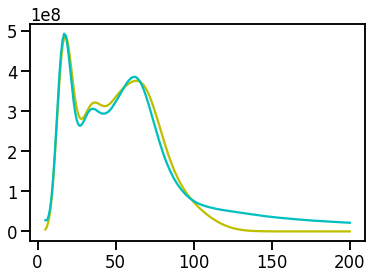

In [238]:
G = np.zeros(16)
G[0:6] = [3.7e8, 1.5e8, 1.1e8, 1.1e8, 2.5e7, 1e7]
lambda_ = 17
rho = 1.6
stacked = generative_model(G, lambda_, rho)
plt.plot(coverage_range, stacked, "y-")
plt.plot(x, y, "c-")

In [219]:
func(17, 1.5, G)

0.6431330311733933

## Optimizer

Optimize one variable at a time.

In [261]:
from scipy.optimize import minimize

def optimize_func(lambda_, rho, G):
    # Iterate over all G
    for i, g in enumerate(G):
        G[i] = optimize_func_Gi(lambda_, rho, G, i)
    lambda_ = optimize_func_lambda_(lambda_, rho, G)
    rho = optimize_func_rho(lambda_, rho, G)
    score = func(lambda_, rho, G)
    return lambda_, rho, G, score

def optimize_func_lambda_(lambda_, rho, G):
    def f(arg):
        if arg <= 1:
            return np.inf
        return func(arg, rho, G)
    res = minimize(f, lambda_, method='nelder-mead', options={'xatol': 0.01})
    return res.x[0]

def optimize_func_rho(lambda_, rho, G):
    def f(arg):
        if arg <= 1:
            return np.inf
        return func(lambda_, arg, G)
    res = minimize(f, lambda_, method='nelder-mead', options={'xatol': 0.001})
    return res.x[0]

def optimize_func_Gi(lambda_, rho, G, i):
    # Iterate a single G_i
    def f(arg):
        if arg < 0: 
            return np.inf
        G[i] = arg
        return func(lambda_, rho, G)
    res = minimize(f, G[i], method='nelder-mead', options={'xatol': 1})
    return res.x[0]

G0 = np.ones(16)
l0 = 17
r0 = 1.6

print(l0, r0, G0)
ll, rr, GG = l0, r0, G0
for i in range(40):
    print("Iteration", i);
    ll, rr, GG, score = optimize_func(ll, rr, GG)
    print(ll, rr, GG, score)

17 1.6 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Iteration 0
16.205893987417227 1.8865326449598758 [4.10145025e+08 1.90405294e+08 1.62759423e+08 9.56909914e+07
 2.44633266e+07 1.39270170e+07 1.00781290e+07 7.12905935e+06
 5.16510495e+06 3.68170735e+06 2.16573895e+06 1.21908735e+06
 1.08961055e+06 2.00764255e+06 7.73652575e+06 5.85712650e+07] 4.7948125306115334e+17
Iteration 1
16.302911724428228 1.7745566734029432 [3.68445712e+08 1.04392064e+08 1.28164487e+08 1.05772551e+08
 2.14141012e+07 9.24286087e+06 7.34522690e+06 5.32618174e+06
 4.20869807e+06 3.45417747e+06 2.19718770e+06 1.17446978e+06
 9.17902868e+05 1.58779479e+06 6.36600640e+06 5.17394067e+07] 7.160497025287052e+16
Iteration 2
16.09207698680136 1.7310996439383612 [3.96903074e+08 1.21679490e+08 1.15759344e+08 1.11703108e+08
 2.22894083e+07 1.06896855e+07 7.96164992e+06 5.31019749e+06
 4.02551913e+06 3.49653049e+06 2.41029590e+06 1.32105807e+06
 9.67250511e+05 1.51734573e+06 5.82544808e+06 4.77298317e+07] 2.850466101792

In [265]:
genome_size = sum((i + 1) * g for i, g in enumerate(GG))
for i, g in enumerate(GG):
    print("Copy-{}: {} ({}%)".format(i + 1, g, (i + 1) * g * 100 / genome_size))

Copy-1: 375102493.1857885 (17.209818623353407%)
Copy-2: 142376400.49450466 (13.064546747988306%)
Copy-3: 96360715.94831346 (13.263178523307527%)
Copy-4: 116190084.05211207 (21.32334824422111%)
Copy-5: 37137588.36946429 (8.519420312552779%)
Copy-6: 10428010.899639484 (2.8706422289162314%)
Copy-7: 9154353.85549407 (2.940032141356945%)
Copy-8: 5676054.230837431 (2.0833530159586977%)
Copy-9: 4841529.456618021 (1.9991778457754636%)
Copy-10: 3030871.0954220137 (1.39057305058066%)
Copy-11: 2558031.8814142803 (1.290996249366424%)
Copy-12: 2222386.6504670205 (1.2235654583043987%)
Copy-13: 1412768.2168309486 (0.8426371664608885%)
Copy-14: 786162.7526240821 (0.504971469868466%)
Copy-15: 897676.6394169237 (0.6177852357995998%)
Copy-16: 14788415.928136315 (10.855953686189105%)


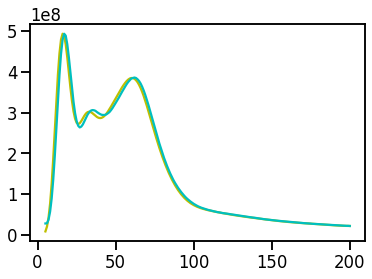

In [262]:
stacked = generative_model(GG, ll, rr)
plt.plot(coverage_range, stacked, "y-")
plt.plot(x, y, "c-")

In [258]:
# Optimize all variables at once
def optimize_func(lambda_, rho, G):
    def f(arg):
        g = np.array(arg[:-2], dtype=np.float64)
        l = arg[-2]
        r = arg[-1]
        if any(x < 0 for x in g):
            return np.inf
        if l <= 1:
            return np.inf
        if r <= 1:
            return np.inf
        return func(l, r, g)
    res = minimize(f, tuple(list(G) + [lambda_, rho]), method='nelder-mead')
    score = func(res.x[-2], res.x[-1], res.x[:-2])
    return res.x[-2], res.x[-1], res.x[:-2], score

G0 = np.ones(16)
l0 = 17
r0 = 1.6

print(l0, r0, G0)
ll, rr, GG = l0, r0, G0
for i in range(20):
    print("Iteration", i);
    ll, rr, GG, score = optimize_func(ll, rr, GG)
    print(ll, rr, GG, score)

17 1.6 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Iteration 0
5.330700851130484 1.0000850504690408 [4.28827787e-05 1.12035607e+00 1.13060374e+00 3.39420169e-01
 6.56746600e-03 7.64727674e-01 1.19678954e+00 2.40915665e+00
 9.16107593e-01 1.49600958e+00 1.45203180e+00 1.94758497e+00
 2.22499795e+00 1.61011780e+00 3.26123002e-03 9.38405121e-01] 8.27761384135489e+18
Iteration 1
5.25912253609812 1.2475241416022569 [1.47293933e-04 8.93390589e-01 4.51473610e-01 1.38660144e-01
 9.05141122e-06 7.13384576e-03 5.11765976e-05 1.02220171e-01
 2.31340552e+00 2.85191999e-01 3.77258109e+00 4.11510068e+00
 5.87882792e+00 3.40561014e+00 2.46636500e-03 6.36700456e-01] 8.277613569049227e+18
Iteration 2
4.986266870563842 1.005385734208728 [4.72799234e-08 1.95248609e+00 4.78152709e-01 1.98533821e-03
 6.27373911e-06 5.19196075e-05 7.92555414e-11 1.55002831e-01
 4.88373026e+00 3.10248054e-04 5.77632330e+00 1.36473695e+00
 2.54249047e+01 5.99964238e+00 1.04390408e-03 1.00270144e+00] 8.277612572387019e+1

## Sequencing error and PCR duplicates (not used)

Assume we have a kmer that has a small error rate $\epsilon$ to generate an erroneous kmer when duplicating. We simulate 8 rounds of PCR.

In [88]:
from random import choice, random
from jcvi.formats.fasta import rc

def generate_kmer(K=21):
    s = ''.join([choice('ATCG') for x in range(K)])
    return min(s, rc(s))

def mutate_kmer(kmer, mu=0.01):
    s = ''.join([(choice('ATCG') if random() < mu else k) for k in kmer])
    return min(s, rc(s))

def evolve(kmer, mu=0.01, start_coverage=1, end_coverage=30):
    pool = [kmer] * max(start_coverage, 1)
    while len(pool) < end_coverage:
        pool += [mutate_kmer(kmer, mu=mu) for kmer in pool]
    return pool[:end_coverage]
        
def summarize(pool):
    from collections import Counter
    for k, v in Counter(pool).items():
        print(k, v)

In [9]:
starting_kmer = generate_kmer()
for i in range(10):
    dup_kmer = mutate_kmer(starting_kmer)
    if dup_kmer == starting_kmer:
        print(starting_kmer)
    else:
        print(starting_kmer, "=>", dup_kmer)

CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA => CTGCCCTGCTTTTATCCAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA


In [70]:
pool = evolve(starting_kmer)
summarize(pool)

CTGCCCTGCTTTTATACAACA 27
CTCCCCTGCTTTTATACAACA 2
CTACCCTGCTTTTATACAACA 1


Now we have a mutation model which takes two parameters: 

- $\mu$ probability of per-base error when duplicating

- $r$ PCR duplication round, this is done with `start_coverage` and `end_coverage`

In [82]:
from functools import lru_cache
from collections import Counter
import sys

@lru_cache(maxsize=None)
def sequencing_model(K=21, mu1000x=10, rho100X=20, target_coverage=30):
    N = 10000
    diff = Counter()
    same = Counter()
    total = 0
    for _ in range(N):
        if i % 100 == 0: print("Sample", i, file=sys.stderr)
        starting_kmer = generate_kmer(K=K)
        pool = evolve(starting_kmer, mu=mu1000x/1000, 
                      start_coverage=target_coverage * rho100X // 100, 
                      end_coverage=target_coverage)
        for pkmer, v in Counter(pool).items():
            if pkmer == starting_kmer:
                same[v] += 1
            else:
                diff[v] += 1
            total += v
    return same, diff, total

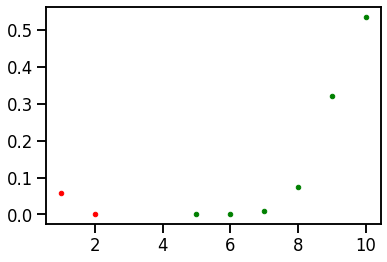

In [90]:
# rho100X is the diversity of starting material, 1 = 1% of the target coverage
mm_same, mm_diff, mm_total = sequencing_model(mu1000x=8, rho100X=50, target_coverage=10)

x, y = zip(*mm_same.items())
z = [_x * _y / mm_total for _x, _y in zip(x, y)]
plt.plot(x, z, ".", color='g')

x, y = zip(*mm_diff.items())
z = [_x * _y / mm_total for _x, _y in zip(x, y)]
plt.plot(x, z, ".", color='r')